In [102]:
!python --version

Python 3.12.7


## Stock price prediction using LSTM

Imports

In [115]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.dates as mdates

from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10

from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))

In [116]:
!pip install --user --upgrade keras tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dropout,Dense, Input

Read the Dataset

In [117]:
df=pd.read_csv("C:/Users/shagu/OneDrive/Desktop/Stock/NSE-Tata-Global-Beverages-Limited.csv")
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
1,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
3,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
4,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05


Analyze the closing prices from dataframe:

In [124]:
# Reset index if the first column was not properly recognized
df.rename(columns={df.columns[0]: "Date"}, inplace=True)
print(df.columns)

Index(['Date', 'High', 'Low', 'Last', 'Close', 'Total Trade Quantity',
       'Turnover (Lacs)'],
      dtype='object')


In [119]:
print(df['Date'].head(10))

0    2018-10-08
1    2018-10-05
2    2018-10-04
3    2018-10-03
4    2018-10-01
5    2018-09-28
6    2018-09-27
7    2018-09-26
8    2018-09-25
9    2018-09-24
Name: Date, dtype: object


In [120]:
# Convert to datetime
df['Date'] = pd.to_datetime(df['Date'], errors="coerce",format = "%Y-%m-%d")
df.set_index('Date',inplace=True)

print(df.head())  # Check if it worked

              Open    High     Low    Last   Close  Total Trade Quantity  \
Date                                                                       
2018-10-08  208.00  222.25  206.85  216.00  215.15             4642146.0   
2018-10-05  217.00  218.60  205.90  210.25  209.20             3519515.0   
2018-10-04  223.50  227.80  216.15  217.25  218.20             1728786.0   
2018-10-03  230.00  237.50  225.75  226.45  227.60             1708590.0   
2018-10-01  234.55  234.60  221.05  230.30  230.90             1534749.0   

            Turnover (Lacs)  
Date                         
2018-10-08         10062.83  
2018-10-05          7407.06  
2018-10-04          3815.79  
2018-10-03          3960.27  
2018-10-01          3486.05  


In [121]:
print(df.index.min(), df.index.max())  # ✅ Should show 2014+
print(df.index.dtype)  # ✅ Should be datetime64[ns]
print(df.head())  # ✅ Check first few rows


2013-10-08 00:00:00 2018-10-08 00:00:00
datetime64[ns]
              Open    High     Low    Last   Close  Total Trade Quantity  \
Date                                                                       
2018-10-08  208.00  222.25  206.85  216.00  215.15             4642146.0   
2018-10-05  217.00  218.60  205.90  210.25  209.20             3519515.0   
2018-10-04  223.50  227.80  216.15  217.25  218.20             1728786.0   
2018-10-03  230.00  237.50  225.75  226.45  227.60             1708590.0   
2018-10-01  234.55  234.60  221.05  230.30  230.90             1534749.0   

            Turnover (Lacs)  
Date                         
2018-10-08         10062.83  
2018-10-05          7407.06  
2018-10-04          3815.79  
2018-10-03          3960.27  
2018-10-01          3486.05  


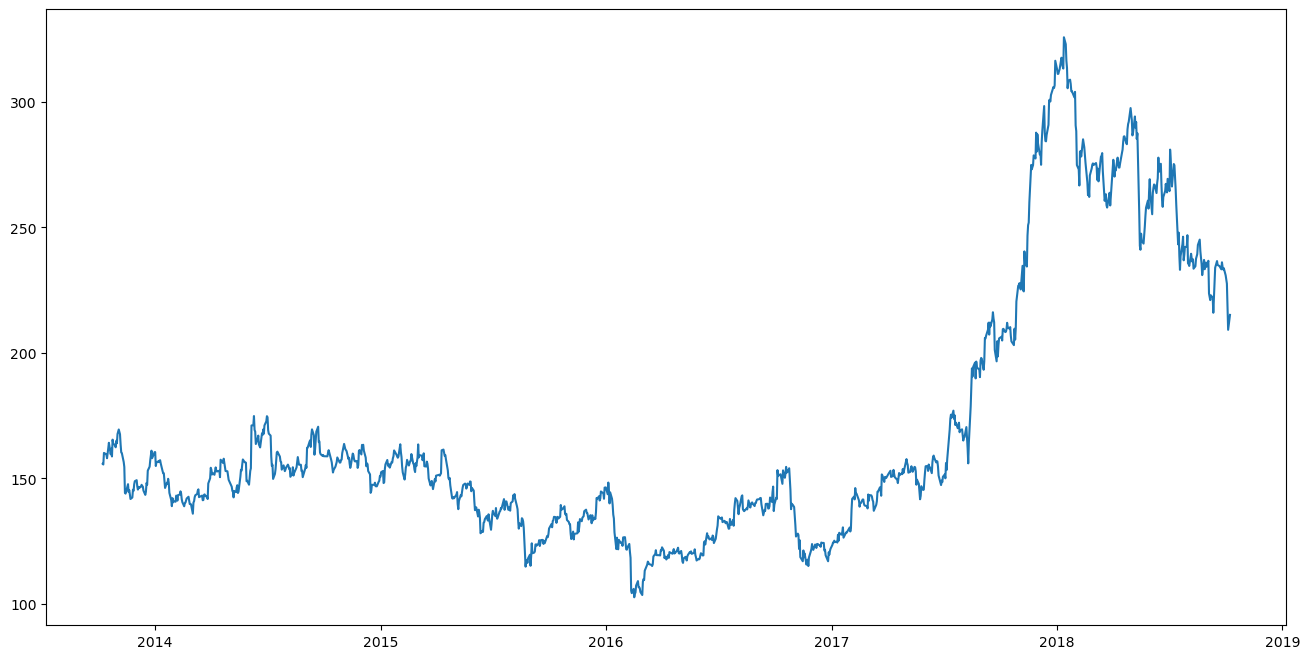

In [122]:
plt.figure(figsize=(16,8))
plt.plot(df["Close"],label='Close Price history')
plt.show()

In [140]:
# Reset index if the first column was not properly recognized
df.rename(columns={df.columns[0]: "Date"}, inplace=True)
print(df.columns)   # Making sure "Date" exists

Index(['Date', 'High', 'Low', 'Last', 'Close', 'Total Trade Quantity',
       'Turnover (Lacs)'],
      dtype='object')


Sort the dataset on date time and filter "Date" and "Close" columns:

In [142]:
# Sort the dataset and create new dataset
df = df.sort_index(ascending=True, axis=0)
new_dataset = pd.DataFrame()
new_dataset["Date"] = df.index  # Use index if Date is not a column
new_dataset["Close"] = df["Close"].values  # Ensure 'Close' exists

In [143]:
new_dataset = df[["Close"]].copy()  # ✅ Copy 'Close' column only
new_dataset.index = pd.to_datetime(new_dataset.index)  # ✅ Ensure datetime index
print(new_dataset.index.min(), new_dataset.index.max())  # ✅ Should show 2014+
print(new_dataset.head())

2013-10-08 00:00:00 2018-10-08 00:00:00
             Close
Date              
2013-10-08  155.80
2013-10-09  155.55
2013-10-10  160.15
2013-10-11  160.05
2013-10-14  159.45


In [147]:
new_dataset.rename(columns={'date':'Date'},inplace=True)
print(new_dataset.columns)
print(new_dataset.index)

Index(['Close'], dtype='object')
DatetimeIndex(['2013-10-08', '2013-10-09', '2013-10-10', '2013-10-11',
               '2013-10-14', '2013-10-15', '2013-10-17', '2013-10-18',
               '2013-10-21', '2013-10-22',
               ...
               '2018-09-24', '2018-09-25', '2018-09-26', '2018-09-27',
               '2018-09-28', '2018-10-01', '2018-10-03', '2018-10-04',
               '2018-10-05', '2018-10-08'],
              dtype='datetime64[ns]', name='Date', length=1235, freq=None)


Normalize the new filtered dataset:

In [150]:

# Convert dataset to numpy array
final_dataset = new_dataset.values  

# Scale the entire dataset
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(final_dataset)

# Split into train and validation sets
train_data = scaled_data[0:987, :]
valid_data = scaled_data[987:, :]

# Prepare training data
x_train_data, y_train_data = [], []

for i in range(60, len(train_data)):
    x_train_data.append(scaled_data[i-60:i, 0])  # Features (past 60 days)
    y_train_data.append(scaled_data[i, 0])  # Target (next day)

# Convert lists to numpy arrays
x_train_data, y_train_data = np.array(x_train_data), np.array(y_train_data)

# Reshape input to 3D format for LSTM (samples, timesteps, features)
x_train_data = np.reshape(x_train_data, (x_train_data.shape[0], x_train_data.shape[1], 1))


Build and train the LSTM Model

In [151]:
lstm_model=Sequential()

# Add Input Layer
lstm_model.add(Input(shape=(x_train_data.shape[1],1)))

# LSTM Layers
lstm_model.add(LSTM(units=50,return_sequences=True))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))

# Compile model
lstm_model.compile(loss='mean_squared_error',optimizer='adam')

# Train model
lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)

inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)


927/927 - 25s - 27ms/step - loss: 0.0011


 Take a sample of a dataset to make stock price predictions using the LSTM model:

In [152]:
X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)

X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
predicted_closing_price=lstm_model.predict(X_test)
predicted_closing_price=scaler.inverse_transform(predicted_closing_price)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step


Save the LSTM model:

In [153]:
lstm_model.save("saved_model.keras")

Visualize the predicted stock costs with actual stock costs:

In [154]:
train_data=new_dataset[:987]
valid_data=new_dataset[987:]
valid_data = new_dataset.iloc[987:].copy()
valid_data["Predictions"]=predicted_closing_price

print(valid_data.index.min(), valid_data.index.max())  # ✅ Should print a range from 2014+
print(valid_data.head())  # ✅ Check the first few rows, especially the index


2017-10-09 00:00:00 2018-10-08 00:00:00
             Close  Predictions
Date                           
2017-10-09  208.30   205.610016
2017-10-10  208.45   206.721329
2017-10-11  209.40   207.333176
2017-10-12  212.00   207.714859
2017-10-13  210.25   208.345062


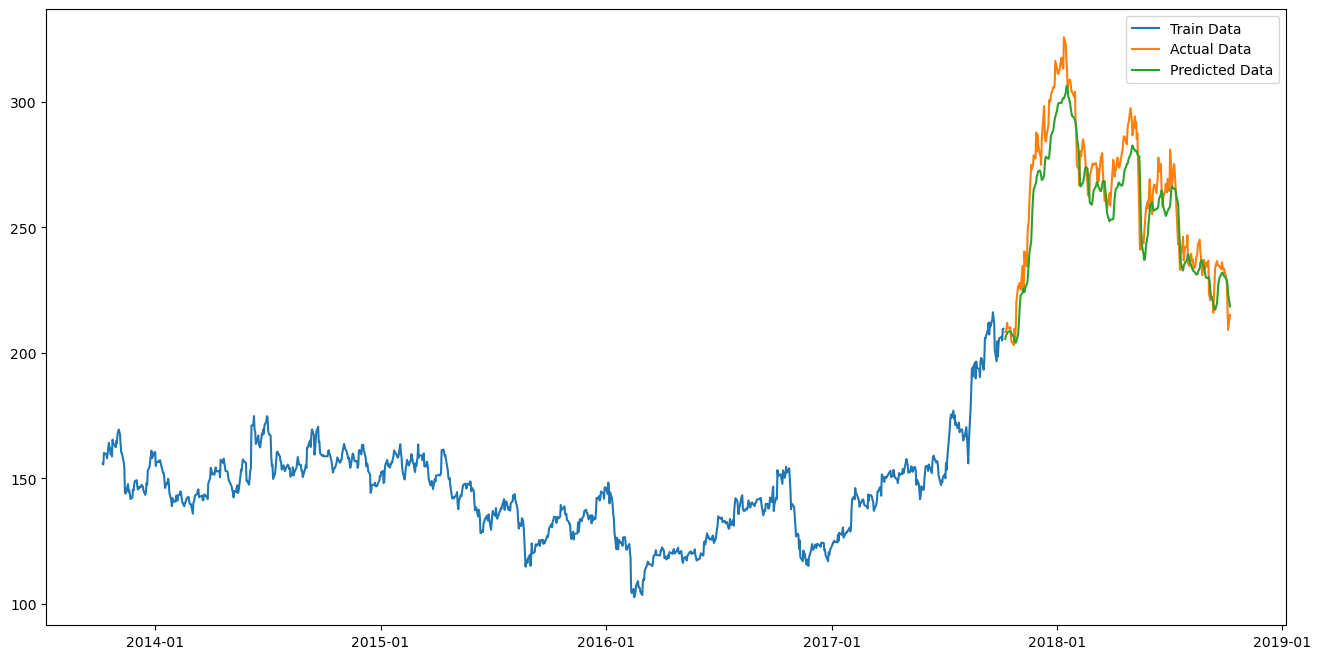

In [155]:
plt.figure(figsize=(16, 8))
plt.plot(train_data.index, train_data["Close"], label="Train Data")
plt.plot(valid_data.index, valid_data["Close"], label="Actual Data")
plt.plot(valid_data.index, valid_data["Predictions"], label="Predicted Data")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # ✅ Format x-axis properly
plt.legend()
plt.show()

You can observe that LSTM has predicted stocks almost similar to actual stocks.